# Billboard Hot 100:  Data Analysis

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; In this notebook, we'll take a look at the Billboard Hot 100 list from the year 2000.  After some exploratory data analysis, we will do a hypothesis test on our findings.   

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from datetime import datetime
from scipy.stats import ttest_ind

%matplotlib inline

## Import data

In [2]:
music = pd.read_csv('assets/billboard.csv', encoding = 'ISO-8859-1')
print(len(music))
music.head(2)

317


,year,artist.inverted,track,time,genre,date.entered,date.peaked,x1st.week,x2nd.week,x3rd.week,...,x67th.week,x68th.week,x69th.week,x70th.week,x71st.week,x72nd.week,x73rd.week,x74th.week,x75th.week,x76th.week
0,2000,Destiny's Child,Independent Women Part I,"3,38,00 AM",Rock,"September 23, 2000","November 18, 2000",78,63,49,...,*,*,*,*,*,*,*,*,*,*
1,2000,Santana,"Maria, Maria","4,18,00 AM",Rock,"February 12, 2000","April 8, 2000",15,8,6,...,*,*,*,*,*,*,*,*,*,*


## Clean columns

### year

In [3]:
music['year'].value_counts()

2000    317
Name: year, dtype: int64

In [4]:
## all same year, drop
music.drop('year', axis = 1, inplace = True)

### artist.inverted

In [5]:
music['artist.inverted'].value_counts().head()

Jay-Z                5
Dixie Chicks, The    4
Houston, Whitney     4
DMX                  3
Martin, Ricky        3
Name: artist.inverted, dtype: int64

In [6]:
## fix last name, first name
music['artist'] = [' '.join([x.split(', ')[1], x.split(',')[0]]) if ',' in x else x for x in music['artist.inverted']]
music.drop('artist.inverted', axis = 1, inplace = True)
music['artist'].value_counts().head()

Jay-Z                 5
Whitney Houston       4
The Dixie Chicks      4
Christina Aguilera    3
Alan Jackson          3
Name: artist, dtype: int64

### track

In [7]:
music['track'].value_counts()[music['track'].value_counts() != 1]

Where I Wanna Be    2
Name: track, dtype: int64

In [8]:
## one duplicate title; check
music.loc[music['track'] == 'Where I Wanna Be', ['artist', 'track', 'date.entered']]

,artist,track,date.entered
118,Donell Jones,Where I Wanna Be,"April 22, 2000"
305,Shade Sheist,Where I Wanna Be,"November 11, 2000"


### time

In [9]:
## convert time to decimal minutes
music['time'] = [x.replace(',00 AM', '').split(',') for x in music['time']]
music['time'] = [(int(x[0])*60 + int(x[1]))/60. for x in music['time']]

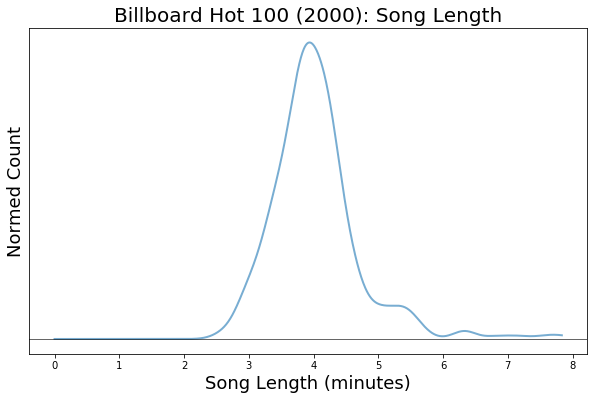

In [10]:
plt.figure(figsize = (10, 6))

density = gaussian_kde(music['time'])
xs = np.linspace(0, music['time'].max(), 1000)
density.covariance_factor = lambda : 0.25
density._compute_covariance()
plt.plot(xs, density(xs), linewidth = 2, alpha = 0.6)

plt.title('Billboard Hot 100 (2000): Song Length', fontsize = 20)
plt.ylabel('Normed Count', fontsize = 18)
plt.yticks([])
plt.xlabel('Song Length (minutes)', fontsize = 18)
plt.grid(False)
plt.axhline(0, color = 'black', alpha = 0.6, lw = 1)

plt.show();

### genre

In [11]:
music['genre'].value_counts()

Rock           103
Country         74
Rap             58
Rock'n'roll     34
R&B             13
R & B           10
Pop              9
Latin            9
Electronica      4
Gospel           1
Jazz             1
Reggae           1
Name: genre, dtype: int64

In [12]:
music['genre'] = [x.replace('R & B', 'R&B') for x in music['genre']]
music['genre'].value_counts()

Rock           103
Country         74
Rap             58
Rock'n'roll     34
R&B             23
Pop              9
Latin            9
Electronica      4
Gospel           1
Jazz             1
Reggae           1
Name: genre, dtype: int64

In [13]:
## remove genres with count fewer than 30
toss = list(music['genre'].value_counts()[music['genre'].value_counts() < 30].index)
for lil_genre in toss:
    music = music[music['genre'] != lil_genre]

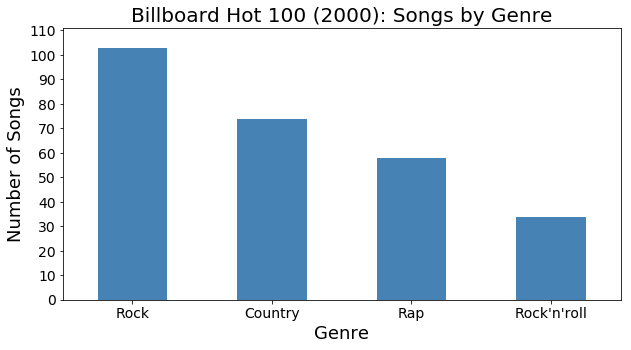

In [14]:
plt.figure(figsize = (10, 5))

y = pd.DataFrame(music['genre'].value_counts())

y['genre'].plot.bar(color = 'steelblue')

plt.title('Billboard Hot 100 (2000): Songs by Genre', fontsize = 20)
# y label
plt.ylabel('Number of Songs', fontsize = 18)
plt.yticks(range(0, 120, 10), fontsize = 14)
plt.ylim([0, 111])
# x label
plt.xlabel('Genre', fontsize = 18)
plt.xticks(rotation = 0, fontsize = 14)
plt.grid(False)
plt.show();

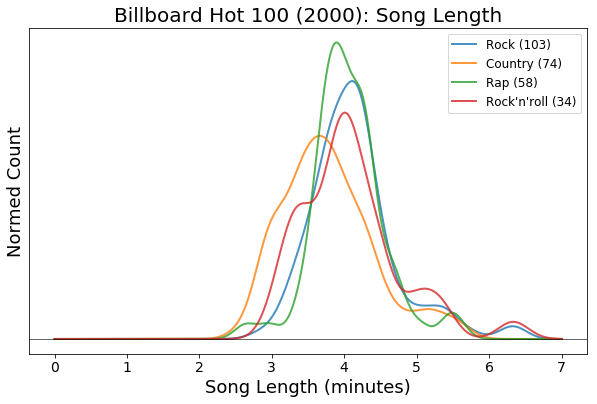

In [15]:
plt.figure(figsize = (10, 6))

for lil_genre in list(music['genre'].value_counts().index):
    lil_music = music[music['genre'] == lil_genre]
    density = gaussian_kde(lil_music['time'])
    xs = np.linspace(0, 1.1*music['time'].max(), 1000)
    density.covariance_factor = lambda : 0.3
    density._compute_covariance()
    plt.plot(
        xs, 
        density(xs), 
        linewidth = 2, 
        label = ' '.join([lil_genre, '({})'.format(len(lil_music))]), 
        alpha = 0.8
    )

plt.title('Billboard Hot 100 (2000): Song Length', fontsize = 20)
plt.ylabel('Normed Count', fontsize = 18)
plt.yticks([])
plt.xlabel('Song Length (minutes)', fontsize = 18)
plt.xticks(fontsize = 14)
plt.grid(False)
plt.legend(loc = 'best', fontsize = 12)
plt.axhline(0, color = 'black', alpha = 0.6, lw = 1)

plt.show();

### date.entered & date.peaked

In [16]:
## date entered hot 100
music['date_entered'] = [datetime.strptime(x, '%B %d, %Y') for x in music['date.entered']]
music['ordinal_entered'] = [x.toordinal() for x in music['date_entered']]

## date peaked hot 100
music['date_peaked'] = [datetime.strptime(x, '%B %d, %Y') for x in music['date.peaked']]
music['ordinal_peaked'] = [x.toordinal() for x in music['date_peaked']]

## calculate time elapsed
music['elapsed'] = [music.loc[i, 'ordinal_peaked'] - music.loc[i, 'ordinal_entered'] for i in list(music.index)]

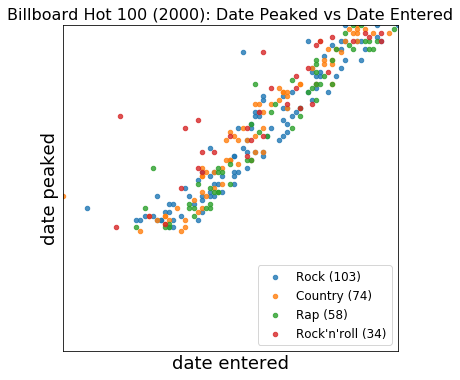

In [17]:
plt.figure(figsize = (6, 6))

for lil_genre in list(music['genre'].value_counts().index):
    lil_music = music[music['genre'] == lil_genre]
    plt.scatter(
        lil_music['ordinal_entered'], 
        lil_music['ordinal_peaked'], 
        s = 20, 
        alpha = 0.8, 
        label = ' '.join([lil_genre, '({})'.format(len(lil_music))]))
plt.title('Billboard Hot 100 (2000): Date Peaked vs Date Entered', fontsize = 16)
plt.xlabel('date entered', fontsize = 18)
plt.xlim([music['ordinal_entered'].min(), music['ordinal_peaked'].max()])
plt.xticks([])
plt.ylabel('date peaked', fontsize = 18)
plt.ylim([music['ordinal_entered'].min(), music['ordinal_peaked'].max()])
plt.yticks([])
plt.legend(loc = 'lower right', fontsize = 12)
plt.show();

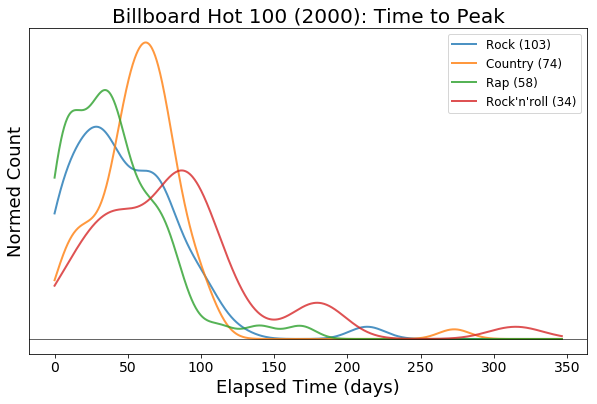

In [18]:
plt.figure(figsize = (10, 6))

for lil_genre in list(music['genre'].value_counts().index):
    lil_music = music[music['genre'] == lil_genre]
    density = gaussian_kde(lil_music['elapsed'])
    xs = np.linspace(0, 1.1*music['elapsed'].max(), 1000)
    density.covariance_factor = lambda : 0.3
    density._compute_covariance()
    plt.plot(xs, density(xs), linewidth = 2, label = ' '.join([lil_genre, '({})'.format(len(lil_music))]), alpha = 0.8)

plt.title('Billboard Hot 100 (2000): Time to Peak', fontsize = 20)
plt.ylabel('Normed Count', fontsize = 18)
plt.yticks([])
plt.xlabel('Elapsed Time (days)', fontsize = 18)
plt.xticks(fontsize = 14)
plt.grid(False)
plt.legend(loc = 'best', fontsize = 12)
plt.axhline(0, color = 'black', alpha = 0.6, lw = 1)

plt.show();

### weekly positions

In [19]:
music.isnull().sum()[music.isnull().sum() != 0]/len(music)

x25th.week    0.869888
x26th.week    0.877323
x27th.week    0.899628
dtype: float64

In [20]:
for i in range(5, 8):
    music['x2{}th.week'.format(i)].fillna(101, inplace = True)

In [21]:
new_weeks = []
for i in list(music.index):
    listlet = [101 if x == '*' else int(x) for x in music.loc[i, 'x1st.week' : 'x76th.week']]
    new_weeks.append(listlet)

music['weeks'] = new_weeks
del new_weeks
music['weeks'].head()

0    [78, 63, 49, 33, 23, 15, 7, 5, 1, 1, 1, 1, 1, ...
1    [15, 8, 6, 5, 2, 3, 2, 2, 1, 1, 1, 1, 1, 1, 1,...
2    [71, 48, 43, 31, 20, 13, 7, 6, 4, 4, 4, 6, 4, ...
3    [41, 23, 18, 14, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2,...
4    [57, 47, 45, 29, 23, 18, 11, 9, 9, 11, 1, 1, 1...
Name: weeks, dtype: object

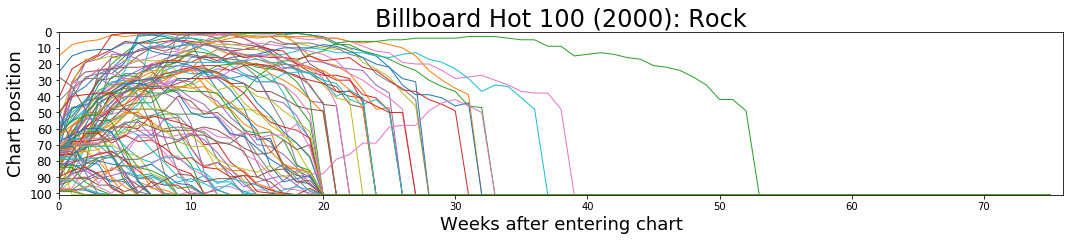

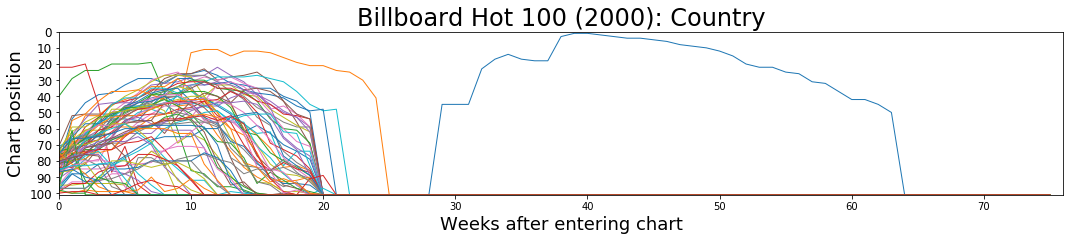

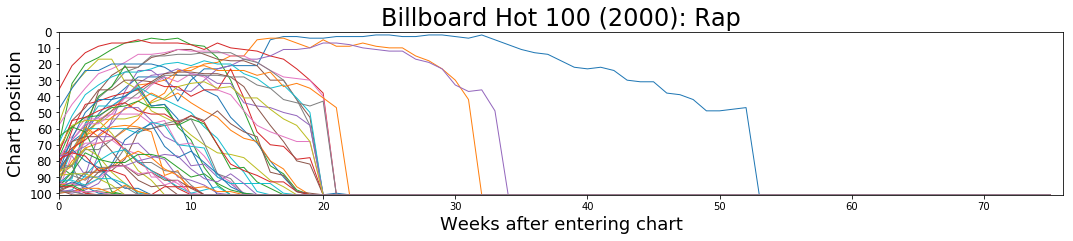

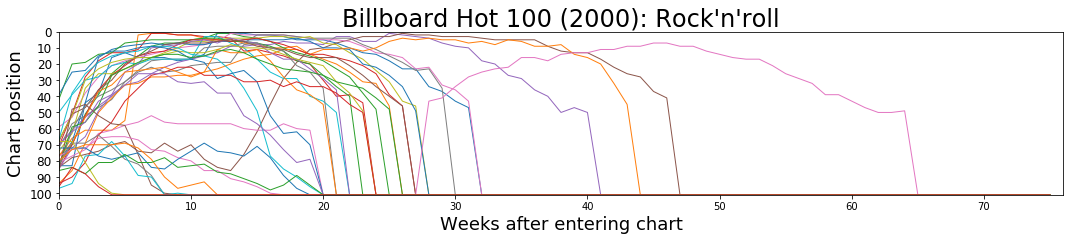

In [22]:
for lil_genre in list(music['genre'].value_counts().index):
    plt.figure(figsize = (18, 3))
    lil_music = music[music['genre'] == lil_genre]
    plt.gca().invert_yaxis()
    for i in list(lil_music.index):
        x = list(range(76))
        y = lil_music.loc[i, 'weeks']
        plt.plot(x, y, lw = 1)
    plt.title(' '.join(['Billboard Hot 100 (2000): {}'.format(lil_genre)]), fontsize = 24)
    plt.ylabel('Chart position', fontsize = 18)
    plt.ylim([101, 1])
    plt.yticks(range(0, 102, 10), fontsize = 12)
    plt.xlabel('Weeks after entering chart', fontsize = 18)
    plt.xlim([0, 76])
    plt.show();

Seems like not many songs take more than 20 weeks to peak; [investigating](http://www.billboard.com/biz/billboard-charts-legend), we find: 

_"RECURRENT RULES_ 
 
_Descending songs are removed from the Billboard Hot 100 and Hot 100 Airplay simultaneously after 20 weeks on the Billboard Hot 100 and if ranking below No. 50."_

In [23]:
music.loc[
    (music['genre'] == 'Rock') & (music['weeks'].apply(lambda x: x[51]) < 101), 
    ['artist', 'track', 'genre']
]

,artist,track,genre
24,3 Doors Down,Kryptonite,Rock


In [24]:
music.loc[
    (music['genre'] == 'Rap') & (music['weeks'].apply(lambda x: x[31]) < 101), 
    ['artist', 'track', 'genre']
]

,artist,track,genre
17,Faith Hill,Breathe,Rap
29,Montell Jordan,Get It On.. Tonite,Rap
47,Nelly,(Hot S**t) Country Grammar,Rap


In [25]:
music.loc[
    (music['genre'] == 'Rock\'n\'roll') & (music['weeks'].apply(lambda x: x[36]) < 101), 
    ['artist', 'track', 'genre']
]

,artist,track,genre
12,Vertical Horizon,Everything You Want,Rock'n'roll
13,Creed,With Arms Wide Open,Rock'n'roll
28,Joe,I Wanna Know,Rock'n'roll
46,Creed,Higher,Rock'n'roll


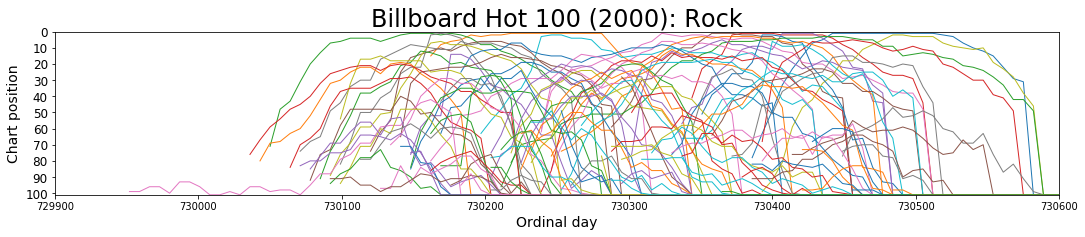

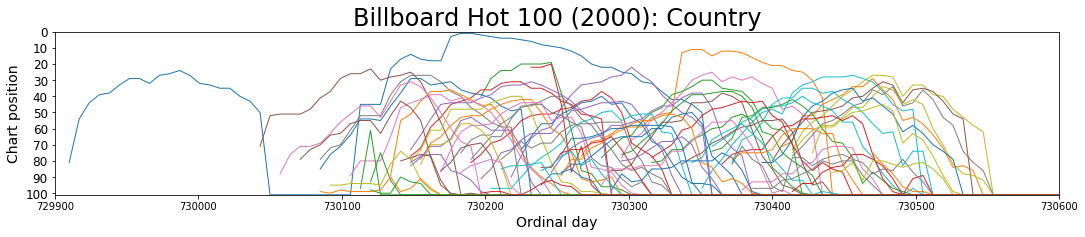

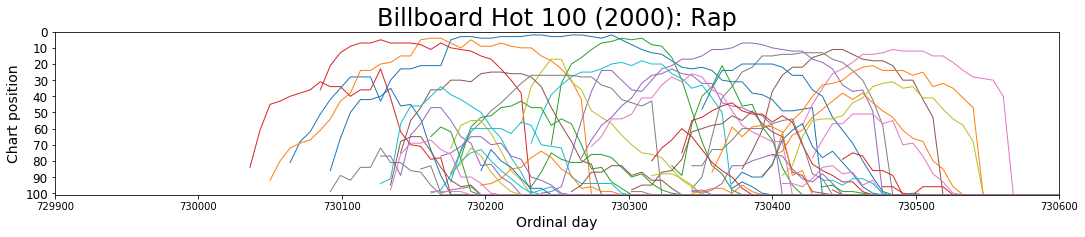

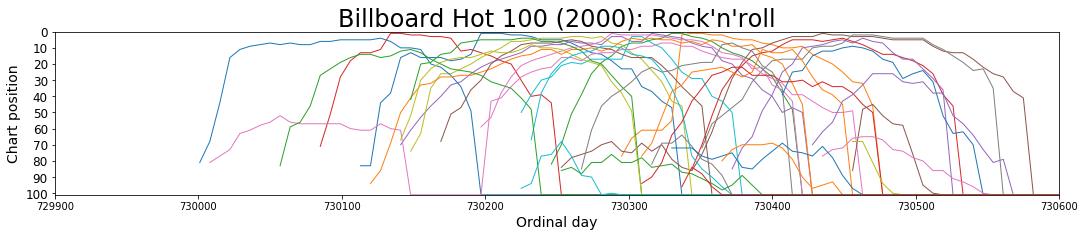

In [26]:
base = [x*7 for x in list(range(76))]
for lil_genre in list(music['genre'].value_counts().index):
    plt.figure(figsize = (18, 3))
    lil_music = music[music['genre'] == lil_genre]
    plt.gca().invert_yaxis()
    for i in list(lil_music.index):
        x = lil_music.loc[i, 'ordinal_entered'] + base
        y = lil_music.loc[i, 'weeks']
        plt.plot(x, y, lw = 1)
    plt.title(' '.join(['Billboard Hot 100 (2000): {}'.format(lil_genre)]), fontsize = 24)
    plt.ylabel('Chart position', fontsize = 14)
    plt.ylim([101, 1])
    plt.yticks(range(0, 102, 10), fontsize = 12)
    plt.xlabel('Ordinal day', fontsize = 14)
    plt.xlim([729900, 730600])
    plt.show();

## entering position & peak position

In [27]:
music['entering_position'] = [x[0] for x in music['weeks']]
music['peak_position'] = [min(x) for x in music['weeks']]

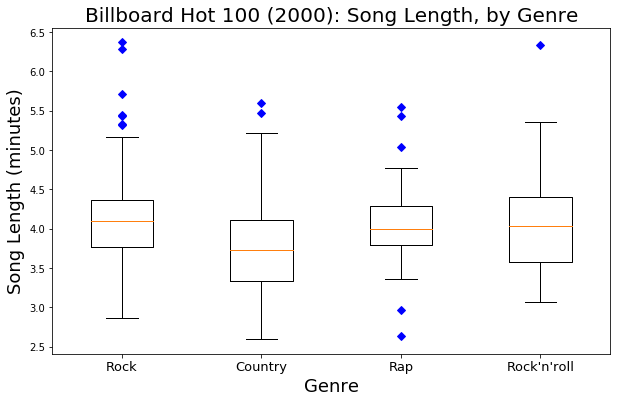

In [28]:
fig, ax1 = plt.subplots(figsize = (10, 6))

data = []

for lil_genre in list(music['genre'].value_counts().index):
    data.append(music.loc[music['genre'] == lil_genre, 'time'].values)

plt.boxplot(data, 0, 'bD')

ax1.set_axisbelow(True)
ax1.set_title('Billboard Hot 100 (2000): Song Length, by Genre', fontsize = 20)
ax1.set_xlabel('Genre', fontsize = 18)
ax1.set_ylabel('Song Length (minutes)', fontsize = 18)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
xtickNames = plt.setp(ax1, xticklabels = list(music['genre'].value_counts().index))
plt.setp(xtickNames, fontsize = 13)

del data

plt.show();

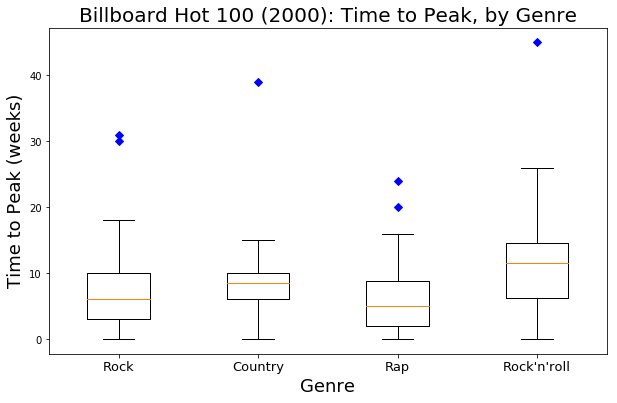

In [29]:
fig, ax1 = plt.subplots(figsize = (10, 6))

data = []

for lil_genre in list(music['genre'].value_counts().index):
    data.append(music.loc[music['genre'] == lil_genre, 'elapsed'].values/7.)

plt.boxplot(data, 0, 'bD')

ax1.set_axisbelow(True)
ax1.set_title('Billboard Hot 100 (2000): Time to Peak, by Genre', fontsize = 20)
ax1.set_xlabel('Genre', fontsize = 18)
ax1.set_ylabel('Time to Peak (weeks)', fontsize = 18)

# Set the axes ranges and axes labels
numBoxes = len(set(music['genre']))
ax1.set_xlim(0.5, numBoxes + 0.5)
xtickNames = plt.setp(ax1, xticklabels = list(music['genre'].value_counts().index))
plt.setp(xtickNames, fontsize = 13)

del data

plt.show();

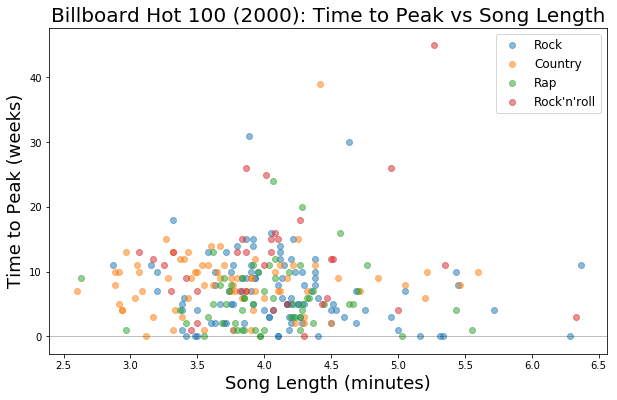

In [30]:
plt.figure(figsize = (10, 6))

for lil_genre in list(music['genre'].value_counts().index):
    y = music[music['genre'] == lil_genre]
    plt.scatter(
        y['time'], 
        y['elapsed'].apply(lambda x: x/7.), 
        alpha = 0.5, 
        label = lil_genre
    )

plt.title('Billboard Hot 100 (2000): Time to Peak vs Song Length', fontsize = 20)

# y label
plt.ylabel('Time to Peak (weeks)', fontsize = 18)

# x label
plt.xlabel('Song Length (minutes)', fontsize = 18)

plt.legend(loc = 'best', fontsize = 12, scatterpoints = 1)
    
plt.axhline(0, color='black', linewidth = 0.5, alpha = 0.5)

plt.show();

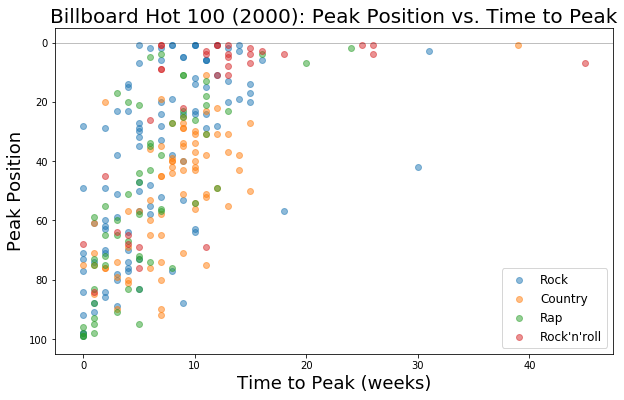

In [31]:
plt.figure(figsize = (10, 6))
for lil_genre in list(music['genre'].value_counts().index):
    y = music[music['genre'] == lil_genre]
    plt.scatter(
        y['elapsed'].apply(lambda x: x/7.), 
        y['peak_position'], 
        alpha = 0.5, 
        label = lil_genre
    )
plt.title('Billboard Hot 100 (2000): Peak Position vs. Time to Peak', fontsize = 20)
# y label
plt.ylabel('Peak Position', fontsize = 18)
# x label
plt.xlabel('Time to Peak (weeks)', fontsize = 18)
plt.gca().invert_yaxis()
plt.legend(loc = 'best', fontsize = 12, scatterpoints = 1)
plt.axhline(0, color = 'black', linewidth = 0.5, alpha = 0.5)
plt.show();

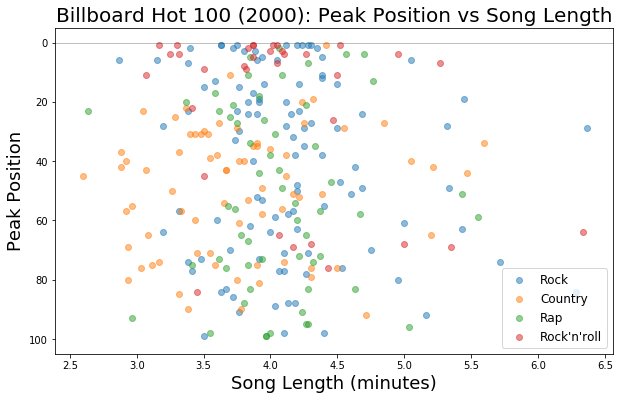

In [32]:
plt.figure(figsize = (10, 6))
for lil_genre in list(music['genre'].value_counts().index):
    y = music[music['genre'] == lil_genre]
    plt.scatter(
        y['time'], 
        y['peak_position'], 
        alpha = 0.5, 
        label = lil_genre
    )
plt.title('Billboard Hot 100 (2000): Peak Position vs Song Length', fontsize = 20)
# y label
plt.ylabel('Peak Position', fontsize = 18)
# x label
plt.xlabel('Song Length (minutes)', fontsize = 18)
plt.gca().invert_yaxis()
plt.legend(loc = 'lower right', fontsize = 12, scatterpoints = 1)   
plt.axhline(0, color = 'black', linewidth = 0.5, alpha = 0.5)
plt.show();

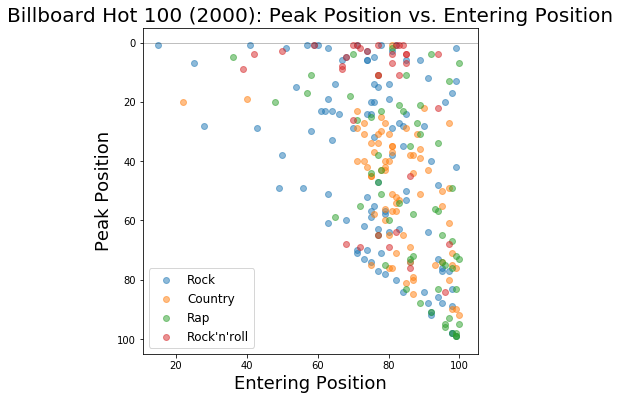

In [33]:
plt.figure(figsize = (6, 6))
for lil_genre in list(music['genre'].value_counts().index):
    y = music[music['genre'] == lil_genre]
    plt.scatter(
        y['entering_position'], 
        y['peak_position'], 
        alpha = 0.5, 
        label = lil_genre
    )
plt.title('Billboard Hot 100 (2000): Peak Position vs. Entering Position', fontsize = 20)
# y label
plt.ylabel('Peak Position', fontsize = 18)
# x label
plt.xlabel('Entering Position', fontsize = 18)
plt.gca().invert_yaxis()
plt.legend(loc = 'best', fontsize = 12, scatterpoints = 1)
plt.axhline(0, color = 'black', linewidth = 0.5, alpha = 0.5)
plt.show();

## Hypothesis Testing

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We hypothesize that the mean peak position attained by "Rock'n'roll" tracks is significantly higher (alpha = 0.05) than the mean peak position attained by "Country" tracks.  Both genres have more than 30 samples, so we will use the t-test for independent samples with unknown mean and unknown standard deviation.  

In [34]:
## peak positions attained by rock'n'roll tracks
sample1 = music.loc[music['genre'] == 'Rock\'n\'roll', 'peak_position']
## peak positions attained by country tracks
sample2 = music.loc[music['genre'] == 'Country', 'peak_position']

## t-test for independence, unequal variance
ttest_ind(sample1, sample2, equal_var = False)

Ttest_indResult(statistic=-4.9862444838854, pvalue=7.829986267117377e-06)

## Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Thus, since p-value << 0.05 in the t-test for independence, we reject the null hypothesis that the mean peak positions are the same for rock'n'roll and country.  As we saw in the plots above (reproduced below with the averages plotted this time), it appears as though the mean peak position attained by rock'n'roll tracks is significantly higher than the mean peak position attained by country tracks.

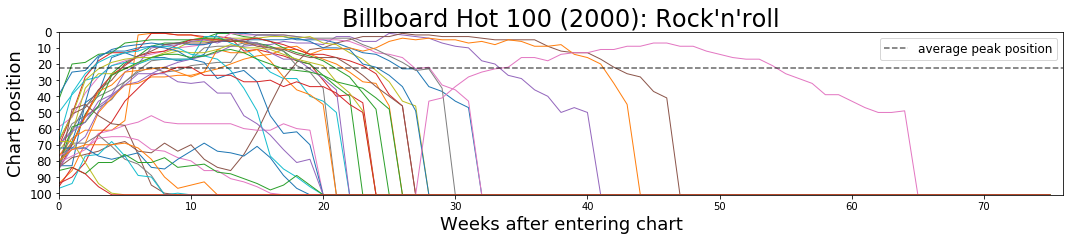

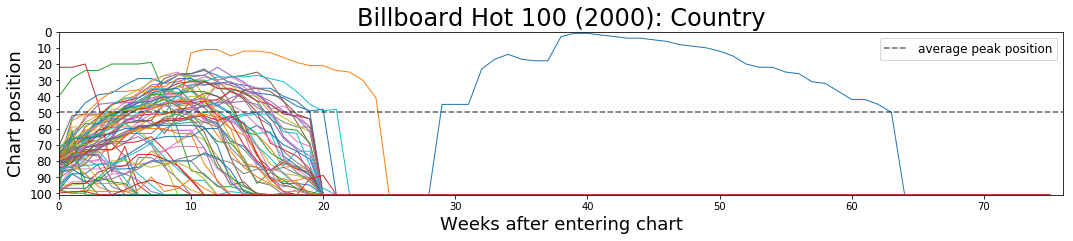

In [35]:
for lil_genre in ['Rock\'n\'roll', 'Country']:
    plt.figure(figsize = (18, 3))
    lil_music = music[music['genre'] == lil_genre]
    plt.gca().invert_yaxis()
    for i in list(lil_music.index):
        x = list(range(76))
        y = lil_music.loc[i, 'weeks']
        plt.plot(x, y, lw = 1)
    plt.title(' '.join(['Billboard Hot 100 (2000): {}'.format(lil_genre)]), fontsize = 24)
    plt.ylabel('Chart position', fontsize = 18)
    plt.ylim([101, 1])
    plt.yticks(range(0, 102, 10), fontsize = 12)
    plt.xlabel('Weeks after entering chart', fontsize = 18)
    plt.xlim([0, 76])
    plt.axhline(
        lil_music['peak_position'].mean(), 
        color = 'k', 
        alpha = 0.6, 
        ls = '--', 
        label = 'average peak position'
    )
    plt.legend(loc = 'best', fontsize = 12)
    plt.show();